In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot as plt, patches

In [2]:
paths = ['/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zero_dt_30_60d_avg.nc',
         '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_avg.nc']
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)
    
etaslice = slice(1,100)
xislice = slice(1,-1)

In [5]:
ds[0].x_rho

<xarray.DataArray 'x_rho' (eta_rho: 194, xi_rho: 194)>
dask.array<open_dataset-5220775390f66f739acefde14a743902x_rho, shape=(194, 194), dtype=float64, chunksize=(194, 194), chunktype=numpy.ndarray>
Coordinates:
    x_rho    (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float64 dask.array<chunksize=(194, 194), meta=np.ndarray>
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 7 ... 186 187 188 189 190 191 192 193
Attributes:
    long_name:  x-locations of RHO-points
    units:      meter
    field:      x_rho, scalar

In [4]:
ds[0].sustr

<xarray.DataArray 'sustr' (ocean_time: 1200, eta_rho: 194, xi_u: 193)>
dask.array<open_dataset-5220775390f66f739acefde14a743902sustr, shape=(1200, 194, 193), dtype=float32, chunksize=(1, 194, 193), chunktype=numpy.ndarray>
Coordinates:
    x_u         (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
    y_u         (eta_rho, xi_u) float64 dask.array<chunksize=(194, 193), meta=np.ndarray>
  * ocean_time  (ocean_time) object 0001-01-01 00:30:00 ... 0001-02-19 23:30:00
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191 192
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 187 188 189 190 191 192 193
Attributes:
    long_name:  time-averaged surface u-momentum stress
    units:      newton meter-2
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   edge1
    field:      surface u-momentum stress, scalar, series

In [3]:
def calc_energy(ds,grid,etaslice,xislice):
    u = xroms.to_rho(ds.u, grid)
    u = u.isel(eta_rho = etaslice, xi_rho = xislice) 
    v = xroms.to_rho(ds.v, grid)
    v = v.isel(eta_rho = etaslice, xi_rho = xislice)
    
    #Do reynold's decomposition
    ubar = u.mean('xi_rho')
    uprime = u-ubar
    vprime = v

    #Mean kinetic energy
    mke = 0.5*ubar**2
    mke_int = (mke*ds.dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mke_initial = (mke*ds.dV).sum(['eta_rho', 'xi_rho', 's_rho'])[0].load() # Initial value for normalization
    mke_int.attrs = ''
    mke_int.name = 'mke'
    mke_initial.attrs = ''
    mke_initial.name = 'mke_initial'

    #Eddy kinetic energy
    eke = 0.5*(uprime**2 + vprime**2)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    eke_int.attrs = ''
    eke_int.name = 'eke'

    #Total kinetic energy 
    tke = 0.5*(u**2+v**2)
    tke_int = (tke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    tke_int.attrs = ''
    tke_int.name = 'tke'     
    
    dse = xr.merge([eke_int, mke_initial, mke_int, tke_int])
    return dse

# dse_zero = calc_energy(ds[0],grid[0],etaslice,xislice)
# dse_zerop1 = calc_energy(ds[1],grid[1],etaslice,xislice)

#Print the initial MKE for both simulations as a QC check
# print(dse_zerop1.mke_initial.values, dse_zerop1.mke_initial.values)

# dse_zero.to_netcdf('shelf_dx_500_mpdata_uwind_osc_zero_dt_30_ene.nc')
# dse_zerop1.to_netcdf('shelf_dx_500_mpdata_uwind_osc_zeropt1_dt_30_ene.nc')

dse_zero = xr.open_dataset('shelf_dx_500_mpdata_uwind_osc_zero_dt_30_ene.nc')
dse_zerop1 = xr.open_dataset('shelf_dx_500_mpdata_uwind_osc_zeropt1_dt_30_ene.nc')

In [4]:
def cal_vint_mixing(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice) #Destruction of salt variance
    #Interpolate to the s-rho points 
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int.name = 'mphy_int'

    ds_mix = xr.merge([mnum_int, mphy_int])
    return ds_mix

# dsm_zero = cal_vint_mixing(ds[0],grid[0],etaslice,xislice)
# dsm_zerop1 = cal_vint_mixing(ds[1],grid[1],etaslice,xislice)

# dsm_zero.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_mix.nc')
# dsm_zerop1.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_mix.nc')

dsm_zero = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_mix.nc')
dsm_zerop1 = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_mix.nc')

In [5]:
def cal_zint_mixing(ds, grid, etaslice, xislice):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int.name = 'mphy_int'

    ds_zmix = xr.merge([mnum_int, mphy_int])
    return ds_zmix

# dszm_zero_top1m = cal_zint_mixing(ds[0],grid[0],etaslice,xislice)
# dszm_zerop1_top1m = cal_zint_mixing(ds[1],grid[1],etaslice,xislice)

# dszm_zero_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_top1m_dt_30_mix.nc')
# dszm_zerop1_top1m.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_top1m_dt_30_mix.nc')

dszm_zero_top1m = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zero_top1m_dt_30_mix.nc')
dszm_zerop1_top1m = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zeropt1_top1m_dt_30_mix.nc')

### Calculate mixed layer depth over initially stratified region. 
> Test cutoff density gradient threshhold value, save them to netcdf

In [21]:
xislice = slice(1,-1) #Exclude boundary points due to periodic BC
etaslice = slice(1,100) #Exclude coastal wall BC, extend to edge of initially stratified region

def calc_mld(ds, thresh):
    rho = 1027*((1+7.6*(10**-4*(ds.salt-35)))-(1.7*10**-4*(ds.temp-25)))
    r1 = rho
    z = r1.z_rho

    mld = xroms.xisoslice(r1 - r1.isel(s_rho=-1) - thresh, 0.0, z, 's_rho')
    
    return mld

#Unforced
mld0_zeropto3 = calc_mld(ds[0],0.03) #0.03 kg/m^3 cutoff
# mld0_zeropto4 = calc_mld(ds[0],0.04) #0.04 kg/m^3 cutoff
# mld0_zeropto5 = calc_mld(ds[0],0.05) #0.05 kg/m^3 cutoff

#Base case
mld1_zeropto3 = calc_mld(ds[1],0.03)
# mld1_zeropto4 = calc_mld(ds[1],0.04)
# mld1_zeropto5 = calc_mld(ds[1],0.05)

### Spatially-average the mixed layer depth at each time and save it to a netdf file 

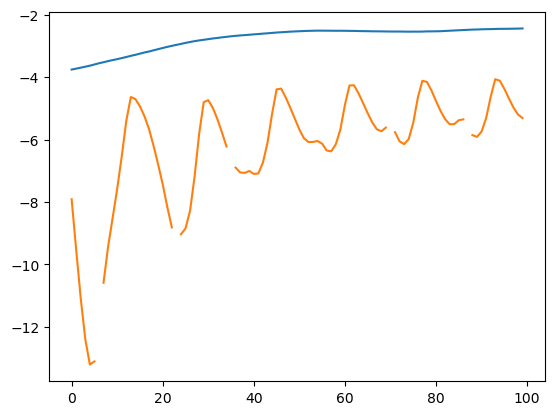

In [88]:
mld0_zeropto3_mean = mld0_zeropto3.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho'], skipna=True).load()
mld1_zeropto3_mean = mld1_zeropto3.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho'], skipna=True).load()

In [111]:
test0 = mld0_zeropto3_mean.where((mld0_zeropto3_mean!=(-np.inf)) & (mld0_zeropto3_mean!=(np.inf)))#.mean(skipna=True)
test1 = mld1_zeropto3_mean.where((mld1_zeropto3_mean!=(-np.inf)) & (mld1_zeropto3_mean!=(np.inf)))#.mean(skipna=True)

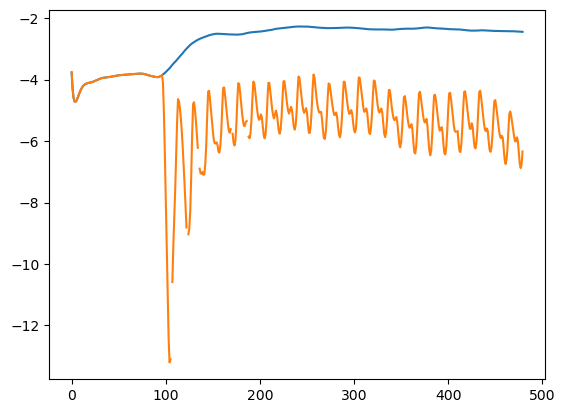

In [112]:
plt.plot(test0[:480])
plt.plot(test1[:480])

In [114]:
print(test0[96:480].mean(skipna=True).values)
print(test1[96:480].mean(skipna=True).values)

-2.4738656160376604
-5.477204258587385


In [22]:
def cal_mld_mixing(ds, grid, etaslice, xislice, mld):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
See Schlichting et al. (2023) JAMES for more information.
    '''
    mnum = ds.dye_03.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice) #Numerical salt mixing
    AKr = grid.interp(ds.AKr, 'Z') #Destruction of salt variance

    mphy = AKr.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.where(ds.z_rho>mld).isel(eta_rho = etaslice, xi_rho = xislice)
    #Volume integrate, then name for concat
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mnum_int.attrs = [] # Remove grid so we can save to netcdf 
    mnum_int.name = 'mnum_int'
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho'])
    mphy_int.name = 'mphy_int'

    ds_mmix = xr.merge([mnum_int, mphy_int])
    return ds_mmix

#0.03 kg/m^4 cutoff
dsm_zero_mld_03 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto3)
dsm_zerop1_mld_03 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto3)

dsm_zero_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto3_dt_30_mix.nc')
dsm_zerop1_mld_03.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto3_dt_30_mix.nc')

# #0.04 kg/m^4 cutoff
# dsm_zero_mld_04 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto4)
# dsm_zerop1_mld_04 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto4)

# dsm_zero_mld_04.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto4_dt_30_mix.nc')
# dsm_zerop1_mld_04.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto4_dt_30_mix.nc')

# #0.05 kg/m^4 cutoff
# dsm_zero_mld_05 = cal_mld_mixing(ds[0],grid[0],etaslice,xislice,mld0_zeropto5)
# dsm_zerop1_mld_05 = cal_mld_mixing(ds[1],grid[1],etaslice,xislice,mld1_zeropto5)

# dsm_zero_mld_05.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto5_dt_30_mix.nc')
# dsm_zerop1_mld_05.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto5_dt_30_mix.nc')

In [23]:
dsm_zero_mld_03 = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zero_mld_zeropto3_dt_30_mix.nc')
dsm_zerop1_mld_03 = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zeropt1_mld_zeropto3_dt_30_mix.nc')

### Quickly compare mixing in top 1 m versus the MLD

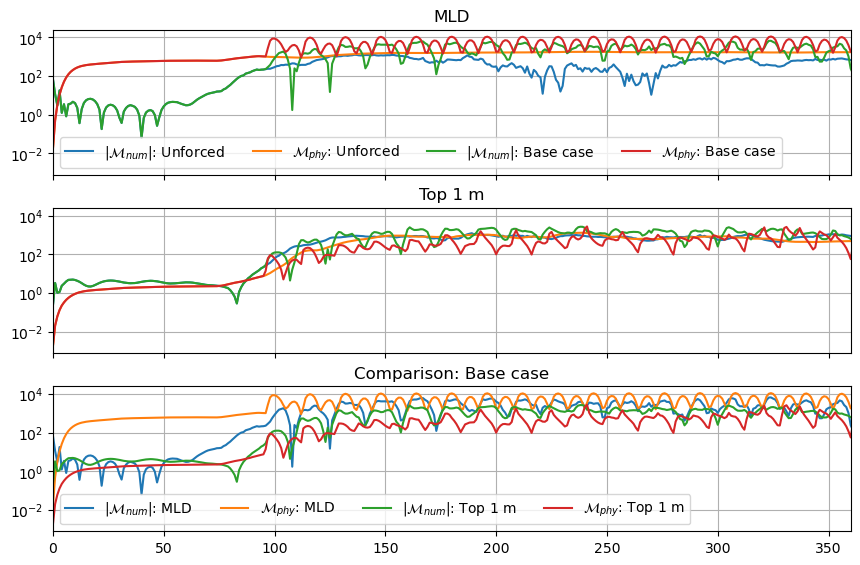

In [40]:
nrows = 3; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,(6/3.25)*nrows), 
                       constrained_layout = True, sharex = True, sharey = True)

ax[0].set_title('MLD')
ax[0].semilogy(np.abs(dsm_zero_mld_03.mnum_int), label = r'$|\mathcal{M}_{num}|$: Unforced')
ax[0].semilogy(dsm_zero_mld_03.mphy_int, label = r'$\mathcal{M}_{phy}$: Unforced')

ax[0].semilogy(np.abs(dsm_zerop1_mld_03.mnum_int), label = r'$|\mathcal{M}_{num}|$: Base case')
ax[0].semilogy(dsm_zerop1_mld_03.mphy_int, label = r'$\mathcal{M}_{phy}$: Base case')
ax[0].legend(ncol = 4)

ax[1].set_title('Top 1 m')
ax[1].semilogy(np.abs(dszm_zero_top1m.mnum_int))
ax[1].semilogy(dszm_zero_top1m.mphy_int)
ax[1].semilogy(np.abs(dszm_zerop1_top1m.mnum_int))
ax[1].semilogy(dszm_zerop1_top1m.mphy_int)

ax[2].set_title('Comparison: Base case')
ax[2].semilogy(np.abs(dsm_zerop1_mld_03.mnum_int), label = r'$|\mathcal{M}_{num}|$: MLD')
ax[2].semilogy(dsm_zerop1_mld_03.mphy_int, label = r'$\mathcal{M}_{phy}$: MLD')
ax[2].semilogy(np.abs(dszm_zerop1_top1m.mnum_int), label = r'$|\mathcal{M}_{num}|$: Top 1 m')
ax[2].semilogy(dszm_zerop1_top1m.mphy_int, label = r'$\mathcal{M}_{phy}$: Top 1 m')
ax[2].legend(ncol = 4)

for i in range(nrows):
    ax[i].set_xlim(0,360)
    ax[i].grid()

In [41]:
def svar_whole(ds, grid, xislice, etaslice):
    ''' 
Returns the three volume-averaged terms for the decomposition of salinity variance: 
total, vertical, and horizontal variance. See Li et al. (2018) JPO for details.
Inputs:
----
ds: DataArray
salt: DataArray
Outputs:
----
svar: total salinity variance
svert: vertical salinity variance
shorz: horizontal salinity variance
    '''
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['s_rho', 'xi_rho', 'eta_rho'])
    
    sbar = (1/V)*((salt*dV).sum(['xi_rho', 'eta_rho','s_rho']))
    sp_tot = (1/V)*((((salt-sbar)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    return sp_tot.load()

# svar_zero = svar_whole(ds[0], grid[0], xislice, etaslice)
# svar_zerop1 = svar_whole(ds[1], grid[1], xislice, etaslice)
# svar_zero.attrs = ''
# svar_zero.name = 'svar'
# svar_zerop1.attrs = ''
# svar_zerop1.name = 'svar'

# svar_zero.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar.nc')
# svar_zerop1.to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar.nc')

svar_zero = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar.nc')
svar_zerop1 = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar.nc')

### Redo this - but also add the vertical and horizontal components 

In [42]:
def sprime2_whole(ds, grid, xislice, etaslice):
    ''' 
Returns the volume-averaged terms for the decomposition of salinity variance: 
total, vertical, and horizontal variance. See Li et al. (2018) JPO for details.
Inputs:
----
ds: DataArray
salt: DataArray
Outputs:
----
svar: total salinity variance
svert: vertical salinity variance
shorz: horizontal salinity variance
    '''
    salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    V = dV.sum(['s_rho', 'xi_rho', 'eta_rho'])
    
    sbar = (1/V)*((salt*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    sp_tot = (1/V)*((((salt-sbar)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    # Now compute the local vertical salinity variance
    dz = ds.dz.isel(eta_rho = etaslice, xi_rho = xislice)
    Z = dz.sum(['s_rho'])
    sbar_z = (1/Z)*((salt*dz).sum(['s_rho']))
    sp_vert = (1/V)*((((salt-sbar_z)**2)*dV).sum(['s_rho', 'xi_rho', 'eta_rho']))
    
    sp_horz = (sp_tot-sp_vert)
    
    sp_tot.attrs = ''
    sp_tot.name = 'svar_tot'
    sp_vert.attrs = ''
    sp_vert.name = 'svar_vert'
    sp_horz.attrs = ''
    sp_horz.name = 'svar_horz'
    
    svar_da = xr.merge([sp_tot, sp_vert, sp_horz])
    
    return svar_da

# svar = []
# for i in range(len(paths)):
#     svar_da = sprime2_whole(ds[i], grid[i], xislice, etaslice)
#     svar.append(svar_da)
    
# svar[0].to_netcdf('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar_decomposed.nc')
# svar[1].to_netcdf('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar_decomposed.nc')

In [43]:
svar_zero = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zero_vint_dt_30_svar_decomposed.nc')
svar_zerop1 = xr.open_dataset('shelf_dx_500_uwind_mpdata_osc_zeropt1_vint_dt_30_svar_decomposed.nc')

### Prepare for plotting by:
> - Opening history file of forcing so values aren't biased by averaging
> - creating a time vector 

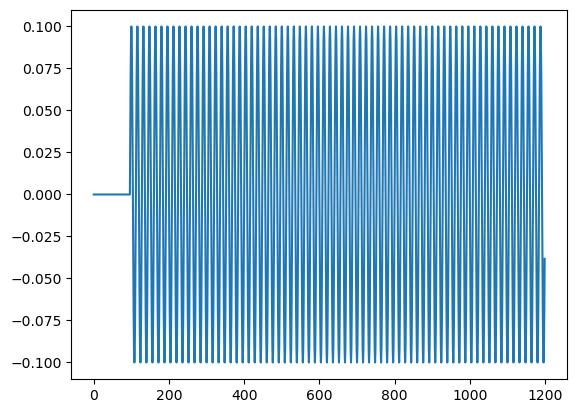

In [44]:
ds_his = xr.open_dataset('/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_his.nc')
plt.plot(ds_his.sustr[0:-1,0,0])

In [47]:
time = np.arange(0,len(ds[1].ocean_time))/24 #Crude time vector, could do this a fancier way but meh. 

### Plot the data 

In [48]:
plt.rcParams.update({'font.size': 10})

In [49]:
mtot_zerop1 = dsm_zerop1.mnum_int+dsm_zerop1.mphy_int
mtot_zero = dsm_zero.mnum_int+dsm_zero.mphy_int

mtot_zerop1_z1 = dszm_zerop1_top1m.mnum_int+dszm_zerop1_top1m.mphy_int
mtot_zero_z1 = dszm_zero_top1m.mnum_int+dszm_zero_top1m.mphy_int

mtot_zerop1_zmld = dsm_zerop1_mld_03.mnum_int+dsm_zerop1_mld_03.mphy_int
mtot_zero_zmld = dsm_zero_mld_03.mnum_int+dsm_zero_mld_03.mphy_int

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


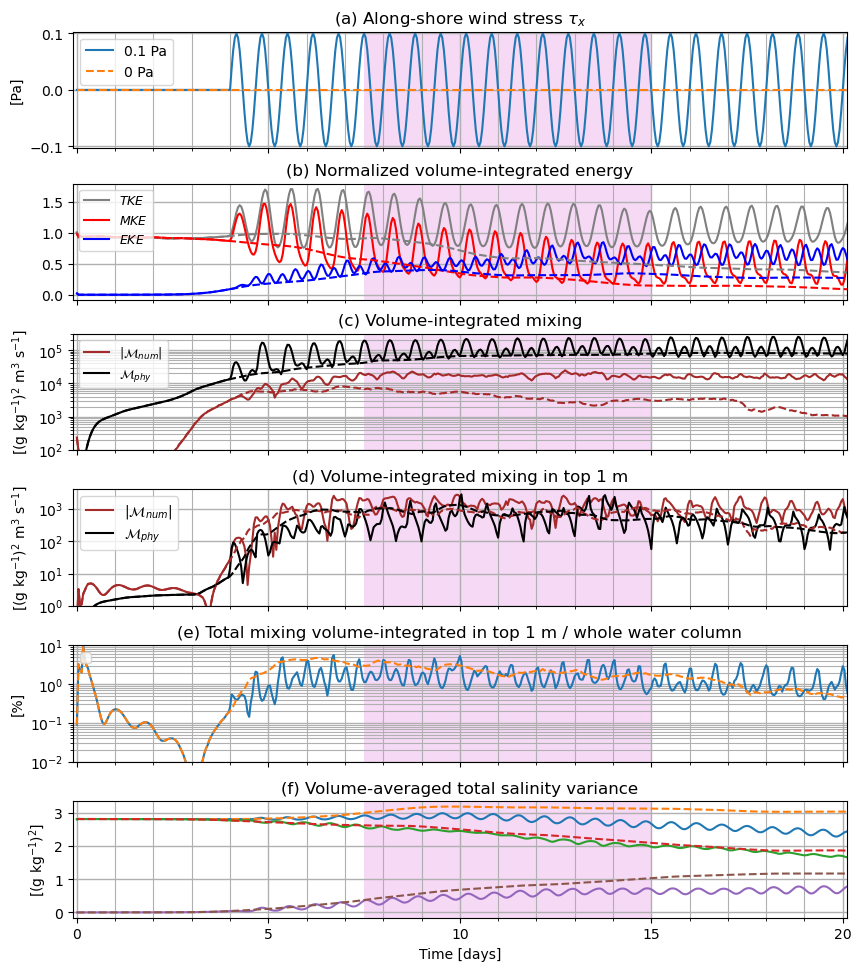

In [50]:
nrows = 6; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,(6/3.75)*nrows), constrained_layout = True, sharex = True)

ax[0].plot(time,ds_his.sustr[0:-1,0,0], label = '0.1 Pa')
ax[0].plot(time,ds_his.sustr[0:-1,0,0]*0, ls = '--', label = '0 Pa')
ax[0].set_xlabel('')
ax[0].set_ylabel(r'[Pa]')
ax[0].set_ylim(-0.103,.103)
ax[0].set_title(r'(a) Along-shore wind stress $\tau_x$')
ax[0].legend(loc = 'upper left')

# ax[0].text(0.2, -0.075, r'$\tau_x$ period $\omega$ = 16 hr')

ax[1].plot(time, dse_zerop1.tke/dse_zerop1.mke_initial, color = 'gray', label = r'$TKE$')
ax[1].plot(time, dse_zerop1.mke/dse_zerop1.mke_initial, color = 'r', label = r'$MKE$')
ax[1].plot(time, dse_zerop1.eke/dse_zerop1.mke_initial, color = 'b', label = r'$EKE$')
ax[1].plot(time, dse_zero.tke/dse_zero.mke_initial, color = 'gray', ls = '--')
ax[1].plot(time, dse_zero.mke/dse_zero.mke_initial, color = 'r', ls = '--')
ax[1].plot(time, dse_zero.eke/dse_zero.mke_initial, color = 'b', ls = '--')

ax[1].set_title('(b) Normalized volume-integrated energy')
ax[1].legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax[2].semilogy(time, np.abs(dsm_zerop1.mnum_int), color = 'brown', label = r'$|\mathcal{M}_{num}|$')
ax[2].semilogy(time, dsm_zerop1.mphy_int, color = 'k', label = r'$\mathcal{M}_{phy}$')
ax[2].semilogy(time, np.abs(dsm_zero.mnum_int), color = 'brown', ls = '--')
ax[2].semilogy(time, dsm_zero.mphy_int, color = 'k', ls = '--')

ax[2].set_title('(c) Volume-integrated mixing')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[2].set_ylim(10**2,10**5.5)
ax[2].legend(loc = 'upper left', ncol = 1,fontsize = 9)
ax[2].yaxis.get_major_locator().set_params(numticks=99)
ax[2].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])

ax[3].semilogy(time, np.abs(dszm_zerop1_top1m.mnum_int), color = 'brown', label = r'$|\mathcal{M}_{num}|$')
ax[3].semilogy(time, dszm_zerop1_top1m.mphy_int, color = 'k', label = r'$\mathcal{M}_{phy}$')
ax[3].semilogy(time, np.abs(dszm_zero_top1m.mnum_int), color = 'brown', ls = '--')
ax[3].semilogy(time, dszm_zero_top1m.mphy_int, color = 'k', ls = '--')

ax[3].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[3].set_ylim(10**0,10**3.6)
ax[3].set_title('(d) Volume-integrated mixing in top 1 m')
ax[3].yaxis.get_major_locator().set_params(numticks=99)
ax[3].legend(loc = 'upper left', ncol = 1)

ax[4].semilogy(time, np.abs(mtot_zerop1_z1/mtot_zerop1)*100)
ax[4].semilogy(time, np.abs(mtot_zero_z1/mtot_zero)*100, ls = '--')
ax[4].set_ylim(1e-2,1e1)
# ax[4].set_xlabel('Time [days]')
ax[4].set_ylabel('[%]')
ax[4].set_title('(e) Total mixing volume-integrated in top 1 m / whole water column')
ax[4].yaxis.get_major_locator().set_params(numticks=99)
ax[4].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])
ax[4].legend(loc = 'upper left')

ax[5].plot(time, svar_zerop1.svar_tot)
ax[5].plot(time, svar_zero.svar_tot, ls = '--')
ax[5].plot(time, svar_zerop1.svar_horz)
ax[5].plot(time, svar_zero.svar_horz, ls = '--')
ax[5].plot(time, svar_zerop1.svar_vert)
ax[5].plot(time, svar_zero.svar_vert, ls = '--')
# ax[5].set_ylim(2.25,3.3)
ax[5].set_xlabel('Time [days]')
ax[5].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[5].set_title('(f) Volume-averaged total salinity variance')

for i in range(nrows):
    ax[i].set_xlim(-0.1,20.1)
    ax[i].set_xticks(np.arange(0,25,5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which = 'major', lw = 1)
    ax[i].grid(which = 'minor')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[0].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[1].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[2].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[3].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[4].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[5].add_patch(rectangle)

# plt.savefig('time_series_shelf_overview.jpg', dpi = 300, bbox_inches='tight')

### Remove the propotion of mixing in top 1 m - it doesn't fit well into the manuscript 

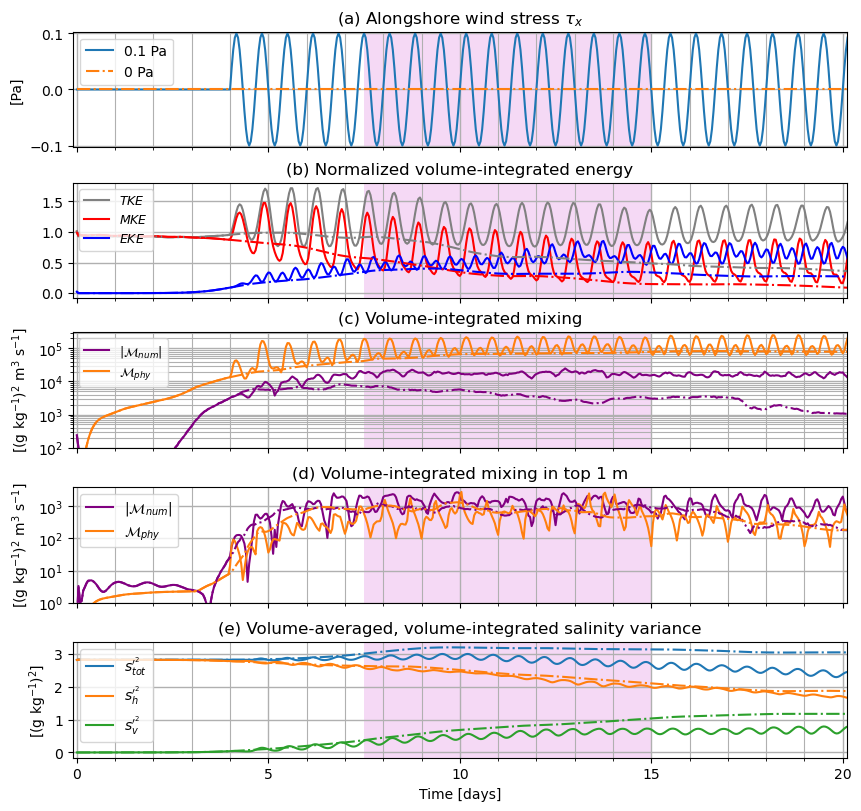

In [33]:
nrows = 5; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,(6/3.75)*nrows), constrained_layout = True, sharex = True)

ax[0].plot(time,ds_his.sustr[0:-1,0,0], label = '0.1 Pa')
ax[0].plot(time,ds_his.sustr[0:-1,0,0]*0, ls = 'dashdot', label = '0 Pa')
ax[0].set_xlabel('')
ax[0].set_ylabel(r'[Pa]')
ax[0].set_ylim(-0.103,.103)
ax[0].set_title(r'(a) Alongshore wind stress $\tau_x$')
ax[0].legend(loc = 'upper left')

ax[1].plot(time, dse_zerop1.tke/dse_zerop1.mke_initial, color = 'gray', label = r'$TKE$')
ax[1].plot(time, dse_zerop1.mke/dse_zerop1.mke_initial, color = 'r', label = r'$MKE$')
ax[1].plot(time, dse_zerop1.eke/dse_zerop1.mke_initial, color = 'b', label = r'$EKE$')
ax[1].plot(time, dse_zero.tke/dse_zero.mke_initial, color = 'gray', ls = 'dashdot')
ax[1].plot(time, dse_zero.mke/dse_zero.mke_initial, color = 'r', ls = 'dashdot')
ax[1].plot(time, dse_zero.eke/dse_zero.mke_initial, color = 'b', ls = 'dashdot')

ax[1].set_title('(b) Normalized volume-integrated energy')
ax[1].legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax[2].semilogy(time, np.abs(dsm_zerop1.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$')
ax[2].semilogy(time, dsm_zerop1.mphy_int, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$')
ax[2].semilogy(time, np.abs(dsm_zero.mnum_int), color = 'purple', ls = 'dashdot')
ax[2].semilogy(time, dsm_zero.mphy_int, color = 'tab:orange', ls = 'dashdot')

ax[2].set_title('(c) Volume-integrated mixing')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[2].set_ylim(10**2,10**5.5)
ax[2].legend(loc = 'upper left', ncol = 1,fontsize = 9)
ax[2].yaxis.get_major_locator().set_params(numticks=99)
ax[2].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])

ax[3].semilogy(time, np.abs(dszm_zerop1_top1m.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$')
ax[3].semilogy(time, dszm_zerop1_top1m.mphy_int, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$')
ax[3].semilogy(time, np.abs(dszm_zero_top1m.mnum_int), color = 'purple', ls = 'dashdot')
ax[3].semilogy(time, dszm_zero_top1m.mphy_int, color = 'tab:orange', ls = 'dashdot')

ax[3].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[3].set_ylim(10**0,10**3.6)
ax[3].set_title('(d) Volume-integrated mixing in top 1 m')
ax[3].yaxis.get_major_locator().set_params(numticks=99)
ax[3].legend(loc = 'upper left', ncol = 1)

ax[4].plot(time, svar_zerop1.svar_tot, color = 'tab:blue', label = r'$s_{tot}^{\prime^2}$')
ax[4].plot(time, svar_zero.svar_tot, color = 'tab:blue', ls = 'dashdot')
ax[4].plot(time, svar_zerop1.svar_horz, color = 'tab:orange', label = r'$s_{h}^{\prime^2}$')
ax[4].plot(time, svar_zero.svar_horz, color = 'tab:orange', ls = 'dashdot')
ax[4].plot(time, svar_zerop1.svar_vert, color = 'tab:green', label = r'$s_{v}^{\prime^2}$')
ax[4].plot(time, svar_zero.svar_vert, color = 'tab:green', ls = 'dashdot')
ax[4].set_xlabel('Time [days]')
ax[4].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[4].set_title('(e) Volume-averaged, volume-integrated salinity variance')
ax[4].legend()

for i in range(nrows):
    ax[i].set_xlim(-0.1,20.1)
    ax[i].set_xticks(np.arange(0,25,5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which = 'major', lw = 1)
    ax[i].grid(which = 'minor')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[0].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[1].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[2].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[3].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[4].add_patch(rectangle)

# plt.savefig('time_series_shelf_overview.png', dpi = 300, bbox_inches='tight')

### Now add in MLD integrated mixing 

### Quickly show volume-integrated mixing relative to MLD

Text(0.5, 0, 'Time [days]')

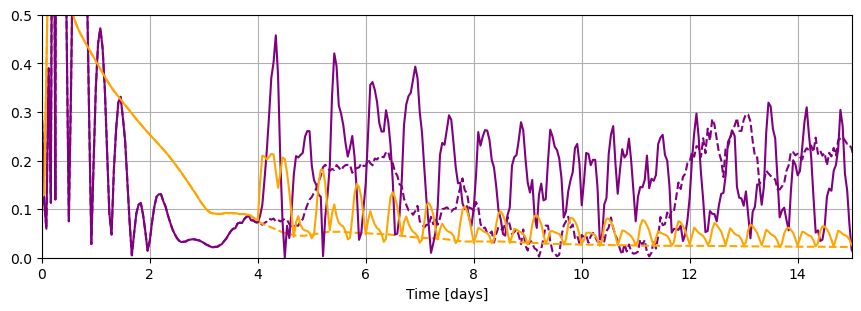

In [77]:
nrows = 1; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,3), constrained_layout = True, sharex = True)

ax.plot(time, np.abs(dsm_zero_mld_03.mnum_int)/np.abs(dsm_zero.mnum_int), color = 'purple', ls = '--', label = r'$|\mathcal{M}_{num}|$')
ax.plot(time, np.abs(dsm_zero_mld_03.mphy_int)/np.abs(dsm_zero.mphy_int), color = 'orange', ls = '--', label = r'$|\mathcal{M}_{num}|$')

ax.plot(time, np.abs(dsm_zerop1_mld_03.mnum_int)/np.abs(dsm_zerop1.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$')
ax.plot(time, np.abs(dsm_zerop1_mld_03.mphy_int)/np.abs(dsm_zerop1.mphy_int), color = 'orange', label = r'$|\mathcal{M}_{num}|$')

ax.set_ylim(0,0.5)
ax.set_xlim(0,15)
ax.grid()
ax.set_xlabel('Time [days]')

### Mixing statistics for initially stratified region
> - Numerical to physical mixing, every other row is base case then unforced. Expressed as a percent
> - Top 1 m next
> - MLD
> - MLD to whole 

In [163]:
print('Whole', "{:.1f}".format((dsm_zerop1.mnum_int[180:361].sum().values)/(dsm_zerop1.mphy_int[180:361].sum().values)*100))
print('Whole', "{:.1f}".format((dsm_zero.mnum_int[180:361].sum().values)/(dsm_zero.mphy_int[180:361].sum().values)*100))

print('Top1m:', "{:.1f}".format((dszm_zerop1_top1m.mnum_int[180:361].sum().values)/(dszm_zerop1_top1m.mphy_int[180:361].sum().values)*100))
print('Top1m:', "{:.1f}".format((dszm_zero_top1m.mnum_int[180:361].sum().values)/(dszm_zero_top1m.mphy_int[180:361].sum().values)*100))

print('MLD:', "{:.1f}".format((dsm_zerop1_mld_03.mnum_int[180:361].sum().values)/(dsm_zerop1_mld_03.mphy_int[180:361].sum().values)*100))
print('MLD:', "{:.1f}".format((dsm_zero_mld_03.mnum_int[180:361].sum().values)/(dsm_zero_mld_03.mphy_int[180:361].sum().values)*100))

print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zerop1_mld_03.mnum_int[180:361].sum().values)/(dsm_zerop1.mnum_int[180:361].sum().values)*100))
print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zero_mld_03.mnum_int[180:361].sum().values)/(dsm_zero.mnum_int[180:361].sum().values)*100))

print('MLD/whole, Mnum:', "{:.1f}".format((dsm_zerop1_mld_03.mphy_int[180:361].sum().values)/(dsm_zerop1.mphy_int[180:361].sum().values)*100))
print('MLD/whole, Mphy:', "{:.1f}".format((dsm_zero_mld_03.mphy_int[180:361].sum().values)/(dsm_zero.mphy_int[180:361].sum().values)*100))

Whole 15.4
Whole 6.5
Top1m: 210.8
Top1m: 104.8
MLD: 49.3
MLD: 24.9
MLD/whole, Mphy: 16.5
MLD/whole, Mphy: 10.0
MLD/whole, Mnum: 5.1
MLD/whole, Mphy: 2.6


In [141]:
print(time[180:361][0],time[180:361][-1])

7.5 15.0


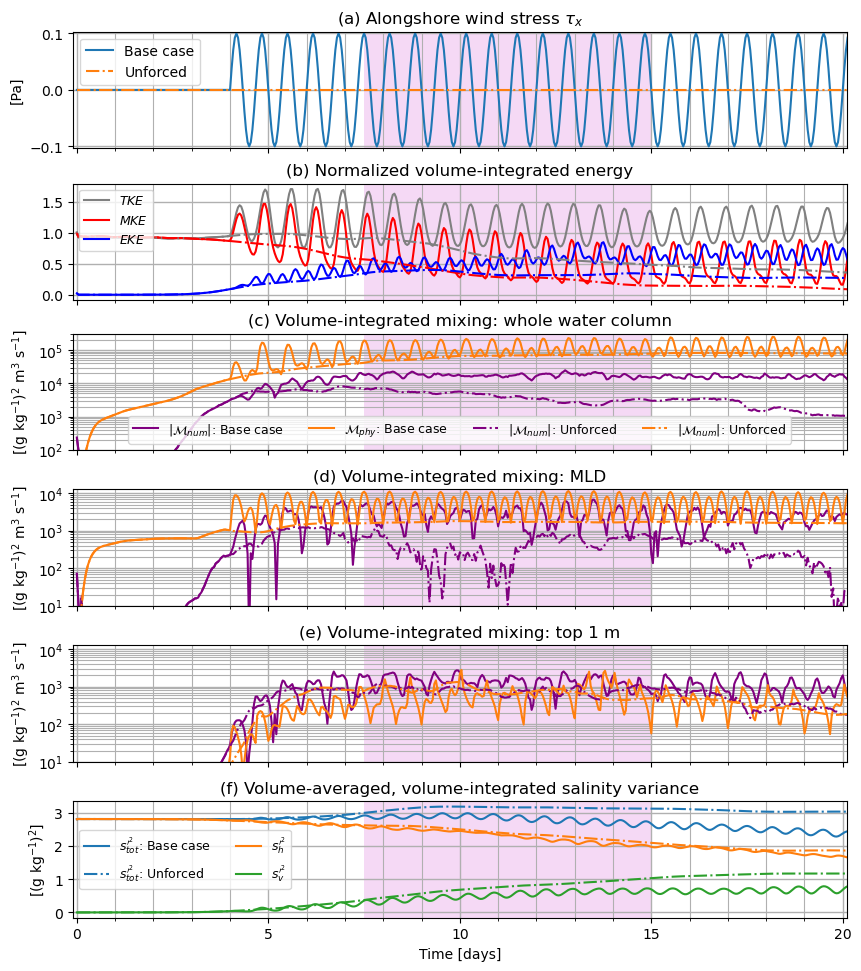

In [160]:
nrows = 6; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (8.5,(6/3.75)*nrows), constrained_layout = True, sharex = True)

ax[0].plot(time,ds_his.sustr[0:-1,0,0], label = 'Base case')
ax[0].plot(time,ds_his.sustr[0:-1,0,0]*0, ls = 'dashdot', label = 'Unforced')
ax[0].set_xlabel('')
ax[0].set_ylabel(r'[Pa]')
ax[0].set_ylim(-0.103,.103)
ax[0].set_title(r'(a) Alongshore wind stress $\tau_x$')
ax[0].legend(loc = 'upper left')

ax[1].plot(time, dse_zerop1.tke/dse_zerop1.mke_initial, color = 'gray', label = r'$TKE$')
ax[1].plot(time, dse_zerop1.mke/dse_zerop1.mke_initial, color = 'r', label = r'$MKE$')
ax[1].plot(time, dse_zerop1.eke/dse_zerop1.mke_initial, color = 'b', label = r'$EKE$')
ax[1].plot(time, dse_zero.tke/dse_zero.mke_initial, color = 'gray', ls = 'dashdot')
ax[1].plot(time, dse_zero.mke/dse_zero.mke_initial, color = 'r', ls = 'dashdot')
ax[1].plot(time, dse_zero.eke/dse_zero.mke_initial, color = 'b', ls = 'dashdot')

ax[1].set_title('(b) Normalized volume-integrated energy')
ax[1].legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax[2].semilogy(time, np.abs(dsm_zerop1.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$: Base case')
ax[2].semilogy(time, dsm_zerop1.mphy_int, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$: Base case')
ax[2].semilogy(time, np.abs(dsm_zero.mnum_int), color = 'purple', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')
ax[2].semilogy(time, dsm_zero.mphy_int, color = 'tab:orange', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')

ax[2].set_title('(c) Volume-integrated mixing: whole water column')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[2].set_ylim(10**2,10**5.5)
ax[2].legend(loc = 'lower center', ncol = 4, fontsize = 9)
ax[2].yaxis.get_major_locator().set_params(numticks=99)
ax[2].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])

ax[3].semilogy(time, np.abs(dsm_zerop1_mld_03.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$: Base case')
ax[3].semilogy(time, dsm_zerop1_mld_03.mphy_int, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$: Base case')
ax[3].semilogy(time, np.abs(dsm_zero_mld_03.mnum_int), color = 'purple', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')
ax[3].semilogy(time, dsm_zero_mld_03.mphy_int, color = 'tab:orange', ls = 'dashdot', label = r'$|\mathcal{M}_{num}|$: Unforced')

ax[3].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[3].set_ylim(10**1,10**4.1)
ax[3].set_title('(d) Volume-integrated mixing: MLD')
ax[3].yaxis.get_major_locator().set_params(numticks=99)
# ax[3].legend(loc = 'upper left', ncol = 1)

ax[4].semilogy(time, np.abs(dszm_zerop1_top1m.mnum_int), color = 'purple', label = r'$|\mathcal{M}_{num}|$')
ax[4].semilogy(time, dszm_zerop1_top1m.mphy_int, color = 'tab:orange', label = r'$\mathcal{M}_{phy}$')
ax[4].semilogy(time, np.abs(dszm_zero_top1m.mnum_int), color = 'purple', ls = 'dashdot')
ax[4].semilogy(time, dszm_zero_top1m.mphy_int, color = 'tab:orange', ls = 'dashdot')

ax[4].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[4].set_ylim(10**1,10**4.1)
ax[4].set_title('(e) Volume-integrated mixing: top 1 m')
ax[4].yaxis.get_major_locator().set_params(numticks=99)
# ax[4].legend(loc = 'upper left', ncol = 1)

ax[5].plot(time, svar_zerop1.svar_tot, color = 'tab:blue', label = r'$s_{tot}^{\prime^2}$: Base case')
ax[5].plot(time, svar_zero.svar_tot, color = 'tab:blue', ls = 'dashdot', label = r'$s_{tot}^{\prime^2}$: Unforced')
ax[5].plot(time, svar_zerop1.svar_horz, color = 'tab:orange', label = r'$s_{h}^{\prime^2}$')
ax[5].plot(time, svar_zero.svar_horz, color = 'tab:orange', ls = 'dashdot')
ax[5].plot(time, svar_zerop1.svar_vert, color = 'tab:green', label = r'$s_{v}^{\prime^2}$')
ax[5].plot(time, svar_zero.svar_vert, color = 'tab:green', ls = 'dashdot')
ax[5].set_xlabel('Time [days]')
ax[5].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[5].set_title('(f) Volume-averaged, volume-integrated salinity variance')
ax[5].legend(loc = 'center left', ncol = 2, fontsize = 9)

for i in range(nrows):
    ax[i].set_xlim(-0.1,20.1)
    ax[i].set_xticks(np.arange(0,25,5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which = 'major', lw = 1)
    ax[i].grid(which = 'minor')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[0].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[1].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[2].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[3].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[4].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[5].add_patch(rectangle)

import matplotlib.ticker

locmin = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(2, 10.0) * 0.1, numticks = 10) 
ax[3].yaxis.set_minor_locator(locmin)
ax[3].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[4].yaxis.set_minor_locator(locmin)
ax[4].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.savefig('time_series_shelf_overview.png', dpi = 300, bbox_inches='tight')

### This looks great. 
The only thing that's unclear what's happening to the unforced case numerical mixing depth integrated over the base of the mixed layer 

### Break into individual subplots 

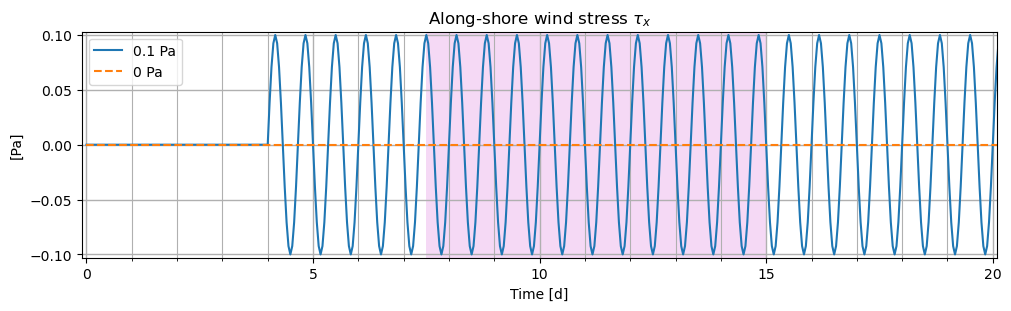

In [36]:
nrows = 1; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (10,3), constrained_layout = True, sharex = True)

ax.plot(time,ds_his.sustr[0:-1,0,0], label = '0.1 Pa')
ax.plot(time,ds_his.sustr[0:-1,0,0]*0, ls = '--', label = '0 Pa')
ax.set_xlabel('')
ax.set_ylabel(r'[Pa]')
ax.set_ylim(-0.103,.103)
ax.set_title(r'Along-shore wind stress $\tau_x$')
ax.legend(loc = 'upper left')

ax.set_xlim(-0.1,20.1)
ax.set_xticks(np.arange(0,25,5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'major', lw = 1)
ax.grid(which = 'minor')
ax.set_xlabel('Time [d]')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax.add_patch(rectangle)
# plt.savefig('time_series_shelf_overview.jpg', dpi = 300, bbox_inches='tight')

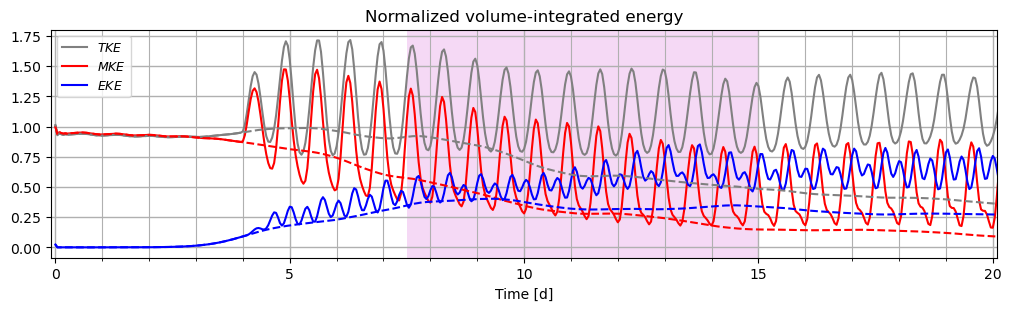

In [37]:
nrows = 1; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (10,3), constrained_layout = True, sharex = True)

ax.plot(time, dse_zerop1.tke/dse_zerop1.mke_initial, color = 'gray', label = r'$TKE$')
ax.plot(time, dse_zerop1.mke/dse_zerop1.mke_initial, color = 'r', label = r'$MKE$')
ax.plot(time, dse_zerop1.eke/dse_zerop1.mke_initial, color = 'b', label = r'$EKE$')
ax.plot(time, dse_zero.tke/dse_zero.mke_initial, color = 'gray', ls = '--')
ax.plot(time, dse_zero.mke/dse_zero.mke_initial, color = 'r', ls = '--')
ax.plot(time, dse_zero.eke/dse_zero.mke_initial, color = 'b', ls = '--')

ax.set_title('Normalized volume-integrated energy')
ax.legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax.set_xlim(-0.1,20.1)
ax.set_xticks(np.arange(0,25,5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'major', lw = 1)
ax.grid(which = 'minor')
ax.set_xlabel('Time [d]')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax.add_patch(rectangle)
# plt.savefig('time_series_shelf_overview.jpg', dpi = 300, bbox_inches='tight')

### Fix aspect ratio for powerpoint, tweak font size as necessary 

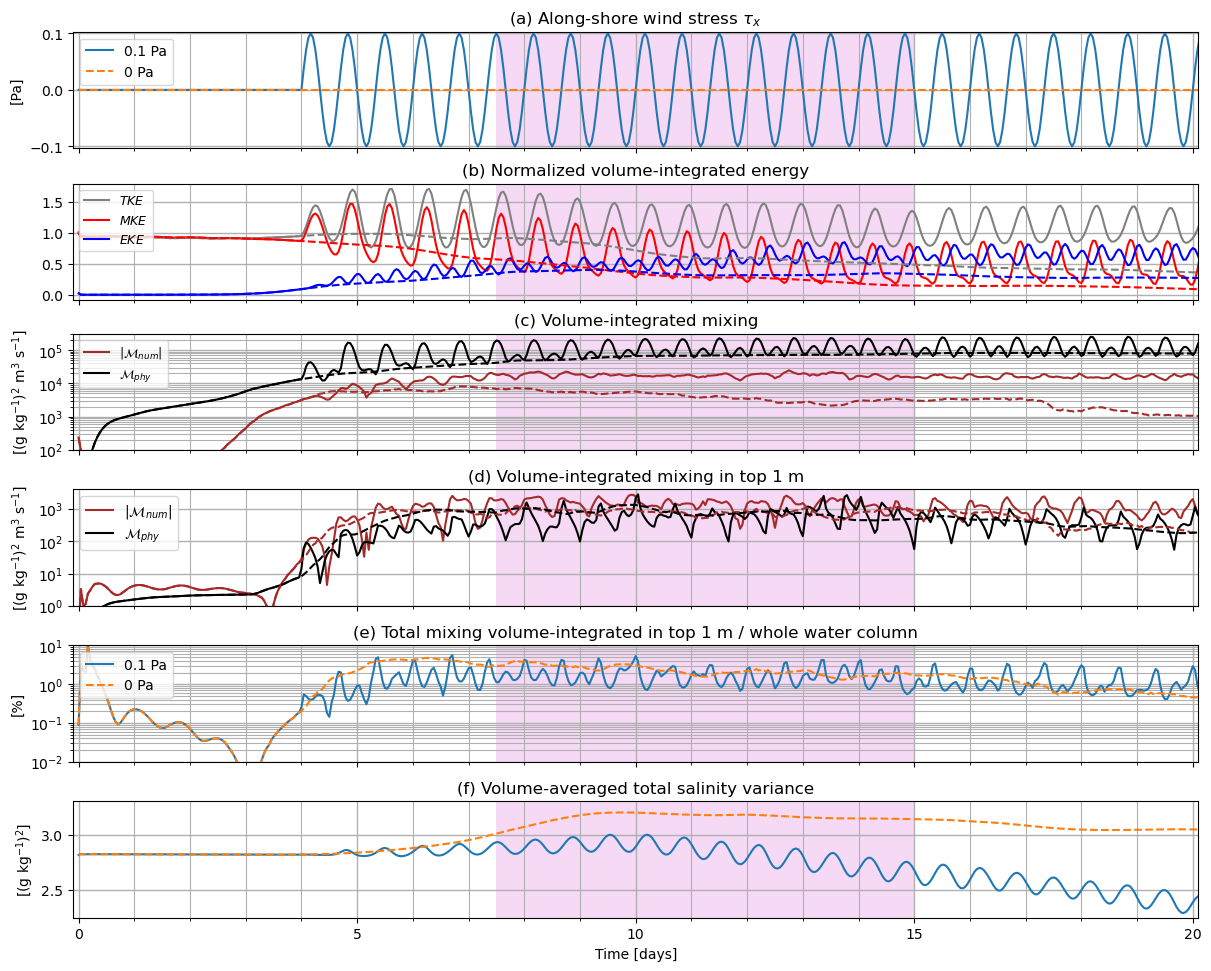

In [23]:
nrows = 6; ncols = 1;
fig, ax = plt.subplots(nrows,ncols, figsize = (12,(6/3.75)*nrows), constrained_layout = True, sharex = True)

ax[0].plot(time,ds_his.sustr[0:-1,0,0], label = '0.1 Pa')
ax[0].plot(time,ds_his.sustr[0:-1,0,0]*0, ls = '--', label = '0 Pa')
ax[0].set_xlabel('')
ax[0].set_ylabel(r'[Pa]')
ax[0].set_ylim(-0.103,.103)
ax[0].set_title(r'(a) Along-shore wind stress $\tau_x$')
ax[0].legend(loc = 'upper left')

# ax[0].text(0.2, -0.075, r'$\tau_x$ period $\omega$ = 16 hr')

ax[1].plot(time, dse_zerop1.tke/dse_zerop1.mke_initial, color = 'gray', label = r'$TKE$')
ax[1].plot(time, dse_zerop1.mke/dse_zerop1.mke_initial, color = 'r', label = r'$MKE$')
ax[1].plot(time, dse_zerop1.eke/dse_zerop1.mke_initial, color = 'b', label = r'$EKE$')
ax[1].plot(time, dse_zero.tke/dse_zero.mke_initial, color = 'gray', ls = '--')
ax[1].plot(time, dse_zero.mke/dse_zero.mke_initial, color = 'r', ls = '--')
ax[1].plot(time, dse_zero.eke/dse_zero.mke_initial, color = 'b', ls = '--')

ax[1].set_title('(b) Normalized volume-integrated energy')
ax[1].legend(loc = 'upper left', ncol = 1,fontsize = 9)

ax[2].semilogy(time, np.abs(dsm_zerop1.mnum_int), color = 'brown', label = r'$|\mathcal{M}_{num}|$')
ax[2].semilogy(time, dsm_zerop1.mphy_int, color = 'k', label = r'$\mathcal{M}_{phy}$')
ax[2].semilogy(time, np.abs(dsm_zero.mnum_int), color = 'brown', ls = '--')
ax[2].semilogy(time, dsm_zero.mphy_int, color = 'k', ls = '--')

ax[2].set_title('(c) Volume-integrated mixing')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[2].set_ylim(10**2,10**5.5)
ax[2].legend(loc = 'upper left', ncol = 1,fontsize = 9)
ax[2].yaxis.get_major_locator().set_params(numticks=99)
ax[2].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])

ax[3].semilogy(time, np.abs(dszm_zerop1_top1m.mnum_int), color = 'brown', label = r'$|\mathcal{M}_{num}|$')
ax[3].semilogy(time, dszm_zerop1_top1m.mphy_int, color = 'k', label = r'$\mathcal{M}_{phy}$')
ax[3].semilogy(time, np.abs(dszm_zero_top1m.mnum_int), color = 'brown', ls = '--')
ax[3].semilogy(time, dszm_zero_top1m.mphy_int, color = 'k', ls = '--')

ax[3].set_ylabel(r'[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
ax[3].set_ylim(10**0,10**3.6)
ax[3].set_title('(d) Volume-integrated mixing in top 1 m')
ax[3].yaxis.get_major_locator().set_params(numticks=99)
ax[3].legend(loc = 'upper left', ncol = 1)

ax[4].semilogy(time, np.abs(mtot_zerop1_z1/mtot_zerop1)*100, label = '0.1 Pa')
ax[4].semilogy(time, np.abs(mtot_zero_z1/mtot_zero)*100, ls = '--', label = '0 Pa')
ax[4].set_ylim(1e-2,1e1)
# ax[4].set_xlabel('Time [days]')
ax[4].set_ylabel('[%]')
ax[4].set_title('(e) Total mixing volume-integrated in top 1 m / whole water column')
ax[4].yaxis.get_major_locator().set_params(numticks=99)
ax[4].yaxis.get_minor_locator().set_params(numticks=99, subs=[.1,.2,.3, .4,.5, .6, .7,.8,.9])
ax[4].legend(loc = 'upper left')

ax[5].plot(time, svar_zerop1.svar)
ax[5].plot(time, svar_zero.svar, ls = '--')
ax[5].set_ylim(2.25,3.3)
ax[5].set_xlabel('Time [days]')
ax[5].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[5].set_title('(f) Volume-averaged total salinity variance')

for i in range(nrows):
    ax[i].set_xlim(-0.1,20.1)
    ax[i].set_xticks(np.arange(0,25,5))
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which = 'major', lw = 1)
    ax[i].grid(which = 'minor')

# Add in rectanges to time series for future figures 
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[0].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 3, facecolor="m", linewidth=7,alpha=0.15)
ax[1].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[2].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[3].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[4].add_patch(rectangle)
rectangle = patches.Rectangle((7.5,-0.2), 7.5, 1000000, facecolor="m", linewidth=7,alpha=0.15)
ax[5].add_patch(rectangle)

# plt.savefig('time_series_shelf_overview.jpg', dpi = 300, bbox_inches='tight')